In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import keras.backend as K

In [87]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 40

In [88]:
files = tf.io.gfile.glob(r"C:/Users/abdul/Desktop/Practicum/Covid recognition/COVID-19 Radiography Database/*/*")

In [89]:
train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)

In [90]:
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

In [91]:
train_normal_count = len([file for file in train_files if 'NORMAL' in file])
train_covid_count = len([file for file in train_files if 'COVID 19' in file])
train_pneumonia_count = len([file for file in train_files if 'Viral Pneumonia' in file])

print(train_normal_count, train_covid_count, train_pneumonia_count)

957 874 966


In [92]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

In [93]:
TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

In [94]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(2797, 700, 389)

In [95]:
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 1
    else: return 2

In [96]:
def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, target

In [97]:
train_data = train_dataset.map(preprocess_img)
val_data = val_dataset.map(preprocess_img)

In [98]:
test_data = test_dataset.map(preprocess_img)
test_data = test_data.batch(BATCH_SIZE)

In [99]:

for img, target in train_data.take(100):
    

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


In [100]:
def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [101]:
train_set = preprocessing(train_data)
val_set = preprocessing(val_data)
# test_set = preprocessing(test_data)

In [102]:
sample_images, sample_targets = next(iter(train_set))

In [103]:
def visualize(images, targets):
    plt.figure(figsize=(12,8))
    for n in range(16):
        sub = plt.subplot(4,4,n+1)
        plt.imshow(images[n])
        if targets[n] == 0:
            plt.title("COVID")
        elif targets[n] == 1:
            plt.title("PNEUMONIA")
        else:plt.title("NORMAL")
        plt.axis("off")

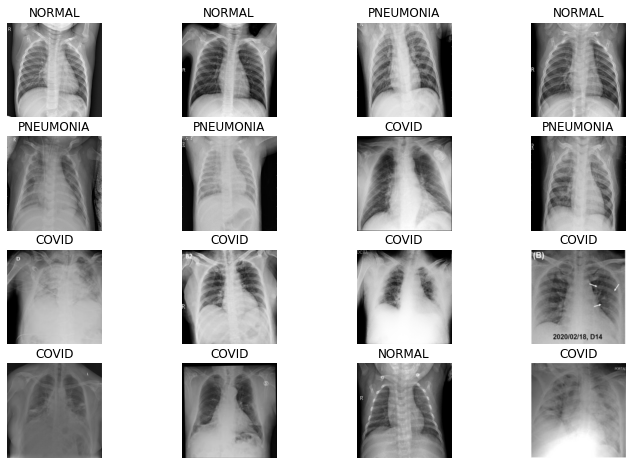

In [104]:
visualize(sample_images.numpy(), sample_targets.numpy())

In [105]:
sample_images[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.32136855, 0.32136855, 0.32136855],
        [0.32687077, 0.32687077, 0.32687077],
        [0.3140056 , 0.3140056 , 0.3140056 ],
        ...,
        [0.10442191, 0.10442191, 0.10442191],
        [0.11182488, 0.11182488, 0.11182488],
        [0.13109271, 0.13109271, 0.13109271]],

       [[0.11592637, 0.11592637, 0.11592637],
        [0.11484594, 0.11484594, 0.11484594],
        [0.0944978 , 0.0944978 , 0.0944978 ],
        ...,
        [0.10532249, 0.10532249, 0.10532249],
        [0.11120449, 0.11120449, 0.11120449],
        [0.11904763, 0.11904763, 0.11904763]],

       [[0.10896359, 0.10896359, 0.10896359],
        [0.11036415, 0.11036415, 0.11036415],
        [0.09801922, 0.09801922, 0.09801922],
        ...,
        [0.09493832, 0.09493832, 0.09493832],
        [0.10206082, 0.10206082, 0.10206082],
        [0.11490627, 0.11490627, 0.11490627]],

       ...,

       [[0.87431514, 0.87431514, 0.87431514],
        [0.75

### Modeling

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    return model

In [54]:
def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
-    Computes the precision, a metric for multi-label classification of 
-    how many selected items are relevant. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
-    Only computes a batch-wise average of recall. 
-    Computes the recall, a metric for multi-label classification of 
-    how many relevant items are selected. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

In [79]:
model = build_model()

METRICS = [
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.Precision()
]
    
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=METRICS
)

In [80]:
model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
sequential_120 (Sequential)  (None, 56, 56, 32)        2160      
_________________________________________________________________
sequential_121 (Sequential)  (None, 28, 28, 64)        7392      
_________________________________________________________________
sequential_122 (Sequential)  (None, 14, 14, 128)       27072     
_________________________________________________________________
dropout_75 (Dropout)         (None, 14, 14, 128)    

In [81]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("covid_model.h5",save_best_only=True)
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_recall', restore_best_weights=True)
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall',
#                 factor=0.2, patience=10, mode='min', min_lr=1E-5)

In [82]:
history = model.fit(
    train_set,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_set,
    validation_steps = VAL_SIZE // BATCH_SIZE
#     callbacks=[checkpoint]
)

Train for 21 steps, validate for 5 steps
Epoch 1/40
 1/21 [>.............................] - ETA: 13s

ValueError: Shapes (None, 3) and (None, 1) are incompatible

In [ ]:
train_data